# Intro to CatBoost

CatBoost is a gradient boosting library that turns simple decision trees into a robust ensemble model for classification and regression. It is also popular for natively handling categorical encoding.

However... what does any of this mean in *human* language?

Let's start from the rudimentary element: **decision trees**.

# Decision Trees

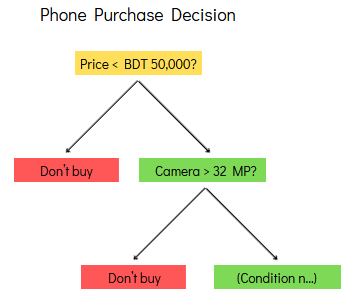

A decision tree is a simple flowchart for making decisions - just like the ones we often contemplate in our daily lives. While searching for a new phone online, we may look for phones below 50,000 taka. Which means if there are any above 50, we don't bother checking its features. For the ones under 50k, we look for 32MP or above camera. If it's below 32MP, we avoid. Turn this into a simple yes/no flowchart and voila, it's a fancy decision tree.

There are models such as Decision Tree Classifiers, using a single tree to develop a predictive algorithm. It works, but it's prone to overfitting (memorizing patterns instead of generalizing) given there's only one tree.



# Gradient Boosting Machines (GBM)

CatBoost is built on Gradient Boosting Machines (GBM), which iteratively construct shallow trees to correct errors from previous ones. In human language: GBMs don’t build one massive tree to guess the outcome. Instead, they build a short tree, check the errors, and figure out what went wrong.

*It’s like leaving your umbrella at home because the forecast said "no rain," only to realize you needed it for the sun. You learn, and that insight gets baked into the next tree. You keep going until the errors are tiny.*

**While rivals like XGBoost and LightGBM are great for speed, CatBoost shines for three specific reasons:**

1. In most models, categorical values need to be encoded to separate numeric values, and often, one-hot encoding is needed. It means instead of having one column (feature) for 50 products with Kitkat as the item, there will be 49 separate binarized columns, with the Kitkat column as 1. It is extremely memory-intensive and complex.
CatBoost handles this hassle through built-in measures. All it takes is a line of code.
2. CatBoost trees are symmetric; meaning, the splits are same per level. It's easier on CPU/GPU while handling massive data load.
3. Instead of looking at the whole dataset at once, it shuffles data to calculate errors based only on prior points. This mimics how the model faces new, unseen data in the real world.

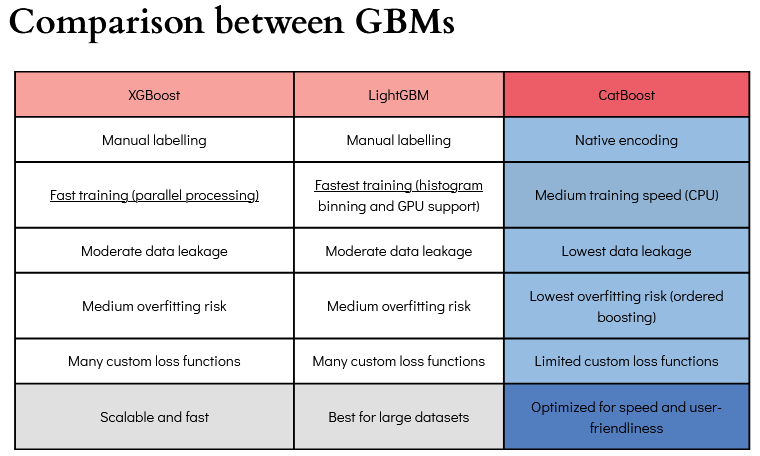

**In this notebook, we will train CatBoost with a Credit Card default dataset consisting around 30,000 instances and 23 features. Afterwards, we will also test with other datasets native to scikit-learn. The objective is to demonstrate the inner workings of CatBoost.**

# Initialization

In [1]:
import pandas as pd
import numpy as np

In [2]:
pip install ucimlrepo

In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [4]:
# copy-pasted the import code from UCI ML Repository

from ucimlrepo import fetch_ucirepo

# fetch dataset

default_of_credit_card_clients = fetch_ucirepo(id=350)

# data (as pandas dataframes)
X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets


# metadata
print(default_of_credit_card_clients.metadata)

# variable information
print(default_of_credit_card_clients.variables)

"""Feature details
X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
X2: Gender (1 = male; 2 = female).
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
X4: Marital status (1 = married; 2 = single; 3 = others).
X5: Age (year).
X6 - X11: History of past payment.
We tracked the past monthly payment records (from April to September, 2005) as follows:
X6 = the repayment status in September, 2005;
X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005.
The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005."""

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

'Feature details\nX1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.\nX2: Gender (1 = male; 2 = female).\nX3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).\nX4: Marital status (1 = married; 2 = single; 3 = others).\nX5: Age (year).\nX6 - X11: History of past payment.\nWe tracked the past monthly payment records (from April to September, 2005) as follows:\nX6 = the repayment status in September, 2005;\nX7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005.\nThe measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.\nX12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amoun

# Training a Credit Card Default Prediction dataset with CatBoost

In [5]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import shap

In [6]:
cat_features = ['X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) # Train-test split at a 4:1 ratio.

model = CatBoostClassifier(iterations=3000, learning_rate=0.08, depth=6, eval_metric='AUC', early_stopping_rounds=100, verbose=False)

''' This is what the hyperparameters mean:
iterations: Number of trees to build in the model.
learning_rate: How much each tree adjusts predictions (smaller = slower, more accurate).
depth: Maximum depth of each tree (controls complexity).
eval_metric: Metric to evaluate model performance (e.g., AUC, Accuracy).
early_stopping_rounds: Stops training if validation performance doesn’t improve for this many rounds.
'''

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)


model.fit(train_pool)

''' cat_features is the list of categorical features to encode natively.
This is one of the greatest utilities of CatBoost - it saves us from the trouble of manually encoding categorical features.'''

' cat_features is the list of categorical features to encode natively.\nThis is one of the greatest utilities of CatBoost - it saves us from the trouble of manually encoding categorical features.'

In [8]:
# renaming all the columns for more clarity

X = X.rename(columns={
    'X1': 'credit_amt',
    'X2': 'gender',
    'X3': 'edu',
    'X4': 'marital_status',
    'X5': 'age',
    'X6': 'repayment_sept',
    'X7': 'repayment_aug',
    'X8': 'repayment_july',
    'X9': 'repayment_june',
    'X10': 'repayment_may',
    'X11': 'repayment_april',
    'X12': 'bill_statement_amt_sept',
    'X13': 'bill_statement_amt_aug',
    'X14': 'bill_statement_amt_july',
    'X15': 'bill_statement_amt_june',
    'X16': 'bill_statement_amt_may',
    'X17': 'bill_statement_amt_april',
    'X18': 'pmt_sept',
    'X19': 'pmt_aug',
    'X20': 'pmt_july',
    'X21': 'pmt_june',
    'X22': 'pmt_may',
    'X23': 'pmt_april'
})

X.sample()

,credit_amt,gender,edu,marital_status,age,repayment_sept,repayment_aug,repayment_july,repayment_june,repayment_may,...,bill_statement_amt_july,bill_statement_amt_june,bill_statement_amt_may,bill_statement_amt_april,pmt_sept,pmt_aug,pmt_july,pmt_june,pmt_may,pmt_april
29886,630000,1,2,1,46,0,0,0,0,0,...,81317,146005,146207,106467,3416,4300,84700,4211,4470,3600


In the next bit of code, we test the accuracy and the level of fit. For that, we need predicted values of y for both test and train data. To measure fit, we use ROC AUC score.

In [9]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
roc_train = roc_auc_score(y_train, y_train_pred)
roc_test = roc_auc_score(y_test, y_pred)

In [10]:
roc_train

np.float64(0.8359693167626105)

In [11]:
roc_test

np.float64(0.6539385323213354)

In [12]:
accuracy_score(y_test, y_pred)

0.8156666666666667

**Evaluation: The ROC-AUC score for train data is more than the test data, which indicates overfitting. Meaning, the model sort of 'memorized' the patterns during training, but failed to generalize them with same accuracy for the test data.**

*Issues of overfitting can be handled by tuning the hyperparameters. For example, if the number of iterations are reduced, the model will capture less complexity/noise. This is the model's version of 'overthinking' - the more trees you create, the more complex patterns it will capture, even though the patterns cannot be generalized. Tree depth can be decreased for the same reason, alongside changing the learning rate.*

In [13]:
model_v2 = CatBoostClassifier(
    iterations=1500, learning_rate=0.1, depth=4, eval_metric='AUC', early_stopping_rounds=100, verbose=False)

model_v2.fit(train_pool)

In [14]:
y_pred = model_v2.predict(X_test)
y_train_pred = model_v2.predict(X_train)
roc_train_v2 = roc_auc_score(y_train, y_train_pred)
roc_test_v2 = roc_auc_score(y_test, y_pred)

In [15]:
roc_train_v2

np.float64(0.704857036934611)

In [16]:
roc_test_v2

np.float64(0.6603379150998752)

In [17]:
accuracy_v2 = accuracy_score(y_test, y_pred)

**Evaluation: In this case, the training ROC-AUC score has reduced a lot and the test ROC has improved, although by 1%. Same goes for the accuracy score. The disparity between training and test AUC has been reduced.**

*Many other hyper-parametric tuning can be done to deal with overfitting/underfitting situations. They include:*

1.   l2_leaf_reg: L2 Regularization to prevent overfitting by penalizing large weights (i.e. possibly overconfident generalizations).
2. bagging_temperature: Controls how much data is randomly sampled for each tree.
3. max_leaves: Maximum number of leaf nodes in a tree (limits/enhances complexity).



# Checking for Data Imbalance

In [18]:
import pandas as pd

# Assuming 'y' is your target variable DataFrame

# Get value counts of the target variable
class_counts = y.value_counts()
display(class_counts)

# Get percentage of each class
class_percentages = y.value_counts(normalize=True) * 100
display(class_percentages)

,count
Y,
0,23364
1,6636


,proportion
Y,
0,77.88
1,22.12


The output above shows the number of instances for each class in the target variable (`y`) and their respective percentages. This helps in identifying if there's a significant imbalance between the classes, which is common in credit default datasets.

In [19]:
from sklearn.utils import class_weight
import numpy as np

# Calculating class weights for y_train
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train.values.ravel()
)
class_weights_dict = dict(zip(classes, weights))

print(f"Calculated class weights: {class_weights_dict}")

model_v3 = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.1,
    depth=4,
    eval_metric='AUC',
    early_stopping_rounds=100,
    verbose=False,
    random_seed=42,
    class_weights=class_weights_dict # Applying calculated class weights
)

model_v3.fit(train_pool, eval_set=test_pool)

y_pred_v3 = model_v3.predict(X_test)
y_train_pred_v3 = model_v3.predict(X_train)

roc_train_v3 = roc_auc_score(y_train, y_train_pred_v3)
roc_test_v3 = roc_auc_score(y_test, y_pred_v3)
accuracy_v3 = accuracy_score(y_test, y_pred_v3)

print(f"\nModel_v3 (with class weights) Performance:")
print(f"Training AUC: {roc_train_v3:.4f}")
print(f"Test AUC: {roc_test_v3:.4f}")
print(f"Test Accuracy: {accuracy_v3:.4f}")

print(f"\nModel_v2 (without class weights) Performance:")
print(f"Training AUC: {roc_train_v2:.4f}")
print(f"Test AUC: {roc_test_v2:.4f}")
print(f"Test Accuracy: {accuracy_v2:.4f}")

Calculated class weights: {np.int64(0): np.float64(0.6425014723992076), np.int64(1): np.float64(2.254367837685516)}

Model_v3 (with class weights) Performance:
Training AUC: 0.7298
Test AUC: 0.7124
Test Accuracy: 0.7537

Model_v2 (without class weights) Performance:
Training AUC: 0.7049
Test AUC: 0.6603
Test Accuracy: 0.8227


The shift in our results — Accuracy dropping from 82% to 75% while ROC-AUC jumping from 0.66 to 0.71 — is the classic signature of a successful intervention in imbalanced data.

The previous model was "lazy"; it achieved high accuracy simply by predicting "No Default" for almost everyone, capitalizing on the fact that most people pay their bills. By applying Class Weights, we forced the model to stop ignoring the minority class.

# Precision-Recall Curve: A Tool for Decision Making

While the ROC curve is standard, the Precision-Recall (PR) Curve is the true test for imbalanced datasets like Credit Default. It forces us to confront the trade-off between "Catching All Defaulters" (Recall) and "Not Annoying Good Customers" (Precision).

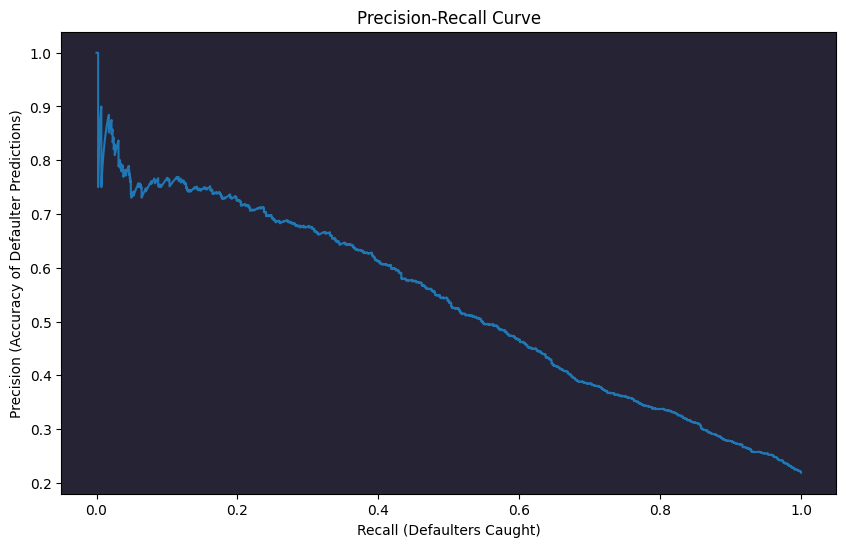

In [20]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Getting probabilities instead of hard 0/1 predictions
y_prob = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.rcParams['figure.facecolor'] = '#262335'
plt.rcParams['axes.facecolor'] = '#262335'

plt.plot(recall, precision)
plt.xlabel('Recall (Defaulters Caught)')
plt.ylabel('Precision (Accuracy of Defaulter Predictions)')
plt.title('Precision-Recall Curve')
plt.show()

Looking at the curve above, we can identify some probable choices:

1. **The "Safe Bets" (Recall 0.0 to 0.2)** At the far left, Precision is near 1.0. This means when the model is extremely confident (predicting only the most obvious cases), it is almost never wrong. It identifies the "guaranteed" defaulters perfectly.

2. **The "Slippery Slope" (Recall 0.2 to 0.8)** As we try to catch more defaulters (moving right on the X-axis), our Precision drops.

    The Trade-off: To catch 60% of all defaulters (Recall = 0.6), we must accept a Precision of roughly 0.5.

    Translation: For every 2 people we flag as "High Risk" in this range, 1 will be a defaulter, but 1 will be a mistake (a false alarm).

**Depending a bank's broad objectives, there can be two options:**

**Strategy A (Risk Averse):** If the bank wants to avoid bad debt at all costs, we pick a threshold at Recall = 0.8. We catch most defaulters, but we will annoy many good customers (Low Precision).

**Strategy B (Customer Focused):** If the bank fears losing reputation by rejecting good people, we pick Recall = 0.2. We only reject the "obvious" risks. We have few false alarms, but we let many defaulters slip through the cracks.

# Feature Importance in CatBoost

^CatBoost has a native method to check feature importance, and it tells us how much a feature reduces impurity or improves overall accuracy. Meaning, the most obvious differentiating factors (e.g. people with income below $1000/yr not buying an iPhone 15) show more weight.

In [21]:
feature_name_map = {
    'X1': 'credit_amt',
    'X2': 'gender',
    'X3': 'edu',
    'X4': 'marital_status',
    'X5': 'age',
    'X6': 'repayment_sept',
    'X7': 'repayment_aug',
    'X8': 'repayment_july',
    'X9': 'repayment_june',
    'X10': 'repayment_may',
    'X11': 'repayment_april',
    'X12': 'bill_statement_amt_sept',
    'X13': 'bill_statement_amt_aug',
    'X14': 'bill_statement_amt_july',
    'X15': 'bill_statement_amt_june',
    'X16': 'bill_statement_amt_may',
    'X17': 'bill_statement_amt_april',
    'X18': 'pmt_sept',
    'X19': 'pmt_aug',
    'X20': 'pmt_july',
    'X21': 'pmt_june',
    'X22': 'pmt_may',
    'X23': 'pmt_april'
}

In [22]:
feature_importance_builtin = model_v2.get_feature_importance(prettified=True)
feature_importance_builtin['feature_name'] = feature_importance_builtin['Feature Id'].map(feature_name_map)
feature_importance_builtin.sort_values(by='Importances', ascending=False)

,Feature Id,Importances,feature_name
0,X6,12.560691,repayment_sept
1,X12,7.615774,bill_statement_amt_sept
2,X1,7.388630,credit_amt
3,X20,6.412510,pmt_july
4,X21,5.963758,pmt_june
5,X19,5.452121,pmt_aug
6,X23,5.443107,pmt_april
7,X18,5.061807,pmt_sept
8,X5,4.868360,age
9,X14,4.784567,bill_statement_amt_july


However... the native method doesn't show **how/why** a feature mattered for a prediction, and how each sample was impacted.

We can use SHAP to do that.

Each row in this SHAP dataframe is a single prediction. Each cell in the row is a signed number. The contribution of that feature to the difference between the model’s base value (average prediction) and this specific prediction.

For example, in the sample indexed 0, value for credit_amt is 0.37 (appx). The base value is -0.3, which is the model's expected prediction if it knew nothing. 0.48 implies that the amount of given credit in the sample pushed the prediction up by 0.48. Similarly, the value of gender pushed the prediction up by 0.05.

In [23]:
shap_values = model_v3.get_feature_importance(test_pool, type='ShapValues')

feature_names = model_v3.feature_names_

all_columns = feature_names + ["base_value"]

shap_df = pd.DataFrame(shap_values, columns=all_columns)

shap_df = shap_df.rename(columns={
    'X1': 'credit_amt',
    'X2': 'gender',
    'X3': 'edu',
    'X4': 'marital_status',
    'X5': 'age',
    'X6': 'repayment_sept',
    'X7': 'repayment_aug',
    'X8': 'repayment_july',
    'X9': 'repayment_june',
    'X10': 'repayment_may',
    'X11': 'repayment_april',
    'X12': 'bill_statement_amt_sept',
    'X13': 'bill_statement_amt_aug',
    'X14': 'bill_statement_amt_july',
    'X15': 'bill_statement_amt_june',
    'X16': 'bill_statement_amt_may',
    'X17': 'bill_statement_amt_april',
    'X18': 'pmt_sept',
    'X19': 'pmt_aug',
    'X20': 'pmt_july',
    'X21': 'pmt_june',
    'X22': 'pmt_may',
    'X23': 'pmt_april'
})

print(shap_df.head())

   credit_amt    gender       edu  marital_status       age  repayment_sept  \
0    0.369551  0.048864  0.053257       -0.059037 -0.018953       -0.305268   
1   -0.025755 -0.034939 -0.064207       -0.049977 -0.021131       -0.350142   
2    0.250169 -0.043377  0.028594        0.065719 -0.018074       -0.336361   
3    0.015850  0.048864  0.030902       -0.056250  0.032924       -0.345853   
4    0.207882 -0.031299  0.051177       -0.052620 -0.014718       -0.325400   

   repayment_aug  repayment_july  repayment_june  repayment_may  ...  \
0      -0.019496       -0.037671       -0.022993      -0.039782  ...   
1      -0.038621       -0.037268       -0.032825      -0.037746  ...   
2      -0.019968       -0.039869       -0.029882      -0.038549  ...   
3      -0.022789       -0.050638       -0.040372      -0.014490  ...   
4      -0.018849       -0.045311       -0.033980      -0.012421  ...   

   bill_statement_amt_june  bill_statement_amt_may  bill_statement_amt_april  \
0           

We can also find the mean absolute SHAP values to check the overall feature importance. Note that the ranking is quite similar to the built-in feature importance analysis, but the weightage is quite different. In both cases, X6 (repayment status in the most recent month) was the most influential predictor.

In [24]:
importance = shap_df.abs().mean().sort_values(ascending=False)
importance

,0
repayment_sept,0.449537
base_value,0.305666
credit_amt,0.220879
bill_statement_amt_sept,0.112751
pmt_sept,0.095740
repayment_july,0.091706
pmt_july,0.074063
pmt_aug,0.072157
pmt_june,0.060831
repayment_may,0.058442


Sometimes, looking at a single feature may be too simplistic in importance analysis. In the real world, **combinations** matter more.

*Example: Being "Male" might not be risky. Being "Male" AND having a "High Credit Limit" might be very risky.*

CatBoost is famous for finding these hidden combinations automatically. We can extract them and see which pairs of variables are driving the decisions.

In [25]:
original_cols = X_test.columns.tolist()

interactions = model_v3.get_feature_importance(
    type="Interaction",
    data=test_pool
)

print("Top 3 Feature Interactions:")
print("-" * 50)

for i in range(3):

    idx1 = int(interactions[i][0])
    idx2 = int(interactions[i][1])
    strength = interactions[i][2]

    orig_name1 = original_cols[idx1]
    orig_name2 = original_cols[idx2]

    readable_name1 = feature_name_map.get(orig_name1, orig_name1)
    readable_name2 = feature_name_map.get(orig_name2, orig_name2)

    print(f"{readable_name1} + {readable_name2} \t(Strength: {strength:.2f})")

Top 3 Feature Interactions:
--------------------------------------------------
repayment_sept + bill_statement_amt_sept 	(Strength: 3.13)
credit_amt + bill_statement_amt_sept 	(Strength: 3.07)
age + bill_statement_amt_sept 	(Strength: 2.37)


# Cross-Validation

Cross-Validation (CV) is a technique used to **assess how well Machine learning models perform on unseen data**. Specifically, there are techniques such as k-fold validation, which evaluate a machine learning model’s performance by dividing the dataset into multiple subsets, or "folds," and testing the model on each one while training on the others. For example, in this 30,000-sample dataset, 5-fold CV was applied, splitting the data into 5 parts (~6,000 samples per test fold, ~24,000 per training fold). Each fold serves as a test set once, with the model trained on the remaining four, and the performance metric (AUC) is averaged across all folds.

CV can provide a more reliable estimate of a model’s performance compared to a single train-test split, especially for real-world applications like predicting default. A single split depends on one random division, which might not represent the full dataset, especially unbalanced ones.

**CV uses all data for testing across folds, reducing the risk of a "lucky" or "bad" split.**

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models and Tools
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cat_cols = ['gender', 'edu', 'marital_status', 'repayment_sept', 'repayment_aug',
            'repayment_july', 'repayment_june', 'repayment_may', 'repayment_april']

num_cols = [col for col in X.columns if col not in cat_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

cb_model = CatBoostClassifier(
    iterations=500,
    depth=4,
    learning_rate=0.05,
    loss_function='Logloss',
    cat_features=cat_cols,
    verbose=0,
    auto_class_weights='Balanced'
)

models = {
    "CatBoost": cb_model,

    "LightGBM": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(n_estimators=500, learning_rate=0.05, class_weight='balanced', verbose=-1))
    ]),

    "XGBoost": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(n_estimators=500, learning_rate=0.05, scale_pos_weight=4, eval_metric='logloss'))
    ]),

    "Logistic Reg": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]),

    "Naive Bayes": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GaussianNB())
    ])
}

results = []
names = []

print(f"{'Model':<15} | {'Mean AUC':<10} | {'Std Dev':<10}")
print("-" * 40)

# 5-Fold Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)

    results.append(cv_scores)
    names.append(name)

    print(f"{name:<15} | {cv_scores.mean():.4f}     | {cv_scores.std():.4f}")

Model           | Mean AUC   | Std Dev   
----------------------------------------
CatBoost        | 0.7833     | 0.0055
LightGBM        | 0.7759     | 0.0067
XGBoost         | 0.7721     | 0.0035
Logistic Reg    | 0.7695     | 0.0063
Naive Bayes     | 0.7392     | 0.0077


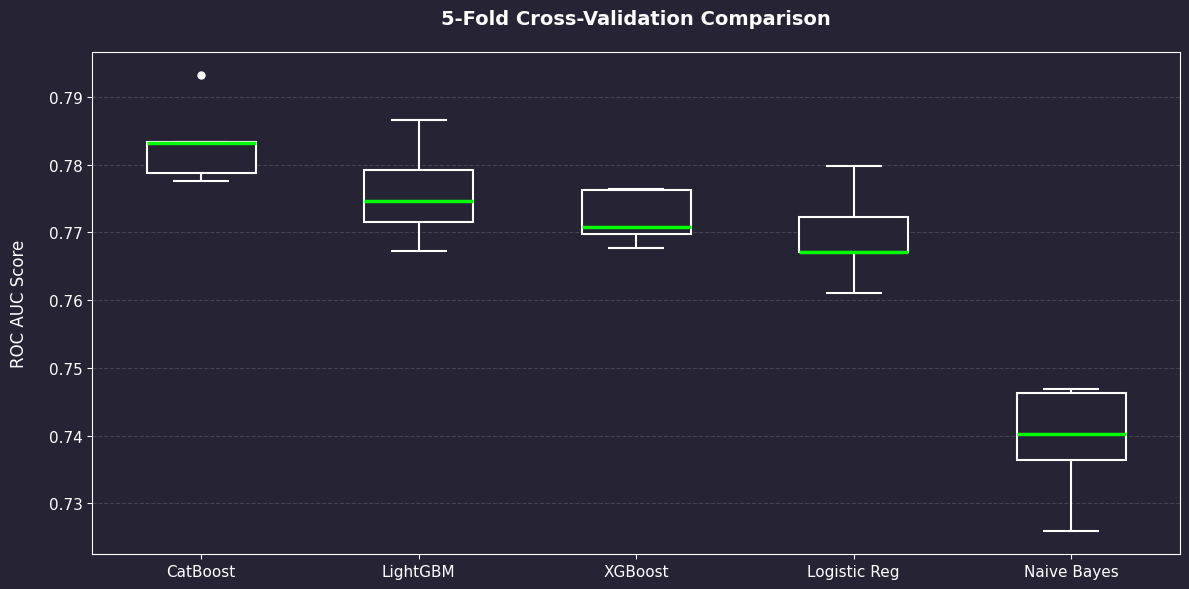


Graph saved successfully as 'model_comparison_dark.png'


In [27]:
df_plot = pd.DataFrame()
for name, scores in zip(names, results):
    temp_df = pd.DataFrame({'Model': name, 'AUC Score': scores})
    df_plot = pd.concat([df_plot, temp_df], ignore_index=True)

BG_COLOR = '#262335'
TEXT_COLOR = 'white'
MEDIAN_COLOR = '#00FF00'

plt.figure(figsize=(12, 6))
fig = plt.gcf()
ax = plt.gca()

fig.patch.set_facecolor(BG_COLOR)
ax.set_facecolor(BG_COLOR)

sns.boxplot(
    data=df_plot,
    x='Model',
    y='AUC Score',
    width=0.5,
    fliersize=5,
    ax=ax,

    boxprops=dict(facecolor=BG_COLOR, edgecolor=TEXT_COLOR, linewidth=1.5),

    whiskerprops=dict(color=TEXT_COLOR, linewidth=1.5),
    capprops=dict(color=TEXT_COLOR, linewidth=1.5),

    medianprops=dict(color=MEDIAN_COLOR, linewidth=2.5),

    flierprops=dict(marker='o', markerfacecolor=TEXT_COLOR, markeredgecolor=TEXT_COLOR)
)

for spine in ax.spines.values():
    spine.set_color(TEXT_COLOR)

ax.tick_params(axis='x', colors=TEXT_COLOR, labelsize=11)
ax.tick_params(axis='y', colors=TEXT_COLOR, labelsize=11)

ax.set_ylabel('ROC AUC Score', color=TEXT_COLOR, fontsize=12, labelpad=15)
ax.set_xlabel('', color=TEXT_COLOR)
ax.set_title('5-Fold Cross-Validation Comparison', color=TEXT_COLOR, fontsize=14, pad=20, fontweight='bold')

ax.grid(True, axis='y', linestyle='--', alpha=0.15, color='white')

plt.tight_layout()
plt.savefig('model_comparison_dark.png', facecolor=BG_COLOR, dpi=300)
plt.show()

print("\nGraph saved successfully as 'model_comparison_dark.png'")

**Interpretation:**

The **CatBoost** model not only achieved the highest median AUC (~0.78) but, more importantly, displayed the shortest box. This indicates Low Variance. Regardless of which subset of customers it was tested on, CatBoost performed consistently well.

While strong contenders, both **XGBoost and LightGBM** showed slightly lower median scores and wider distributions. They struggled slightly more to generalize, likely due to how they handled the specific constraints of this dataset (medium size + categorical dominance).

The significant gap between the **tree-based models** and the **linear/probabilistic baselines** confirms that Credit Default is a non-linear problem. A user's risk isn't a straight line; it's a complex web of interactions (e.g., missing a payment is bad, but missing a payment while having a high balance is catastrophic) that simple models failed to capture.

**CatBoost's performance on this specific dataset is likely driven by two architectural advantages:**

**1. Escaping the "One-Hot" Trap**

The dataset relies heavily on ordinal categorical features (e.g., PAY_0 to PAY_6 representing repayment status).

As mentioned before, other models use one-hot encoding, which explodes a single column into many sparse columns (0s and 1s). This increases dimensionality and makes it harder for the tree to find split points.

CatBoost used Ordered Target Statistics. Instead of blindly encoding categories, it replaced them with the expected risk value derived from the target. This kept the data compact and information-dense. It also prevented data leakage.

**2. Regularization via Symmetric Trees**

Standard GBMs build trees depth-wise or leaf-wise, often creating complex, irregular structures that chase "noise" in the training data.

CatBoost enforces Symmetric Trees (balanced splits at every level). This acts as a structural "brake," preventing the model from creating overly specific rules for outliers. This is why the CatBoost boxplot is so short/stable—it resisted overfitting better than LightGBM.

In [28]:
import graphviz
import xgboost

cb_model = CatBoostClassifier(
    iterations=10,
    depth=2,  # Locked depth for visualization
    learning_rate=0.1,
    verbose=0
)

cb_model.fit(X, y, cat_features=cat_cols) # Changed cat_features to cat_cols

cb_graph = cb_model.plot_tree(
    tree_idx=0,
    pool=Pool(X, y, cat_features=cat_cols, feature_names=list(X.columns)) # Changed cat_features to cat_cols
)

cb_graph.render("my_dataset_catboost_tree", format="png", cleanup=True)
print("Saved 'my_dataset_catboost_tree.png'")

xgb_model = xgboost.XGBClassifier(
    n_estimators=10,
    max_depth=2,
    learning_rate=0.1,
    eval_metric='logloss'
)

xgb_model.fit(X, y)

plt.figure(figsize=(20, 10))
xgboost.plot_tree(xgb_model, num_trees=0, rankdir='TB')
plt.savefig("my_dataset_xgboost_tree.png", dpi=300)
plt.close()

Saved 'my_dataset_catboost_tree.png'


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

**CatBoost Tree:**

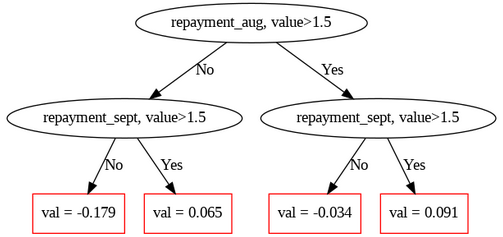

**XGBoost Tree**

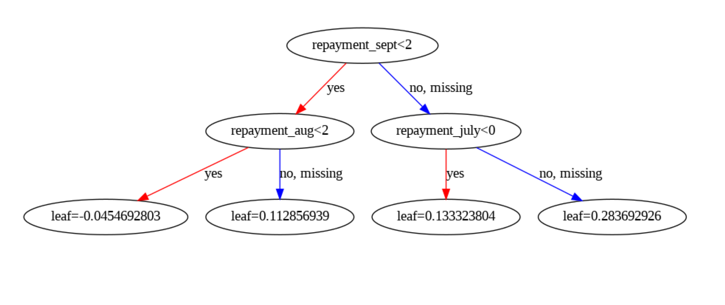

**Tree effect in CatBoost:**

1. Faster (takes less memory space due to less unique values)
2. Robust to overfitting; if DT keeps going on using gini, there may be splits for instances which cannot be generalized (e.g. calling an apple red instead of green because of a pigment that isn't actually found in 99% of red apples)
3. (On the flip side) Not the best for complex datasets where capturing minute differences is crucial; CatBoost may oversimplify in those cases.

# Learning Rate

**Learning rate** is simply a number that controls the impact of each tree's output. Lower learning rate makes the model learn slowly and carefully.

*Let's say, if this model is a golfer, the Learning Rate is the strength of the swing.*

**Fast Learning Rate** is like swinging the club hard. The ball covers a huge distance very quickly. We get near the hole in just 1 or 2 shots. But, because we are swinging so hard, we might overshoot the hole.

**Slow learning rate** is like using a putter and tapping the ball gently. We move very slowly, but we don't overshoot. The ball is put into the hole perfectly.

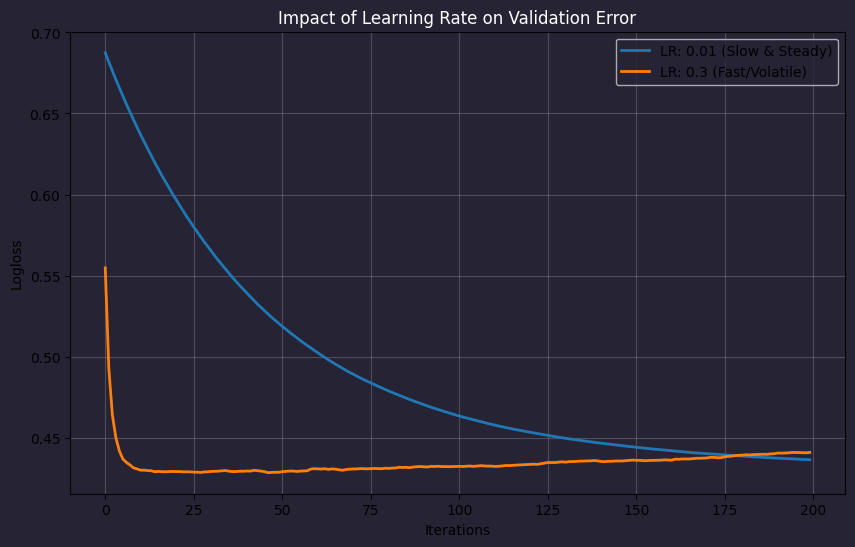

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

learning_rates = [0.01, 0.3]
metrics_history = {}

for lr in learning_rates:

        model = CatBoostClassifier(
            iterations=200,
            learning_rate=lr,
            eval_metric='Logloss',
            use_best_model=False,
            verbose=0
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)]
        )

        results = model.get_evals_result()

        val_key = [k for k in results.keys() if k != 'learn'][0]

        metrics_history[lr] = results[val_key]['Logloss']

plt.figure(figsize=(10, 6))
plt.rcParams['figure.facecolor'] = '#262335'
plt.rcParams['axes.facecolor'] = '#262335'

plt.plot(metrics_history[learning_rates[0]], label=f'LR: {learning_rates[0]} (Slow & Steady)', linewidth=2)

plt.plot(metrics_history[learning_rates[1]], label=f'LR: {learning_rates[1]} (Fast/Volatile)', linewidth=2)

plt.title('Impact of Learning Rate on Validation Error', color='white')
plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.legend()
plt.grid(True, alpha=0.3)

filename = "catboost_learning_rate_comparison.png"
plt.savefig(filename, dpi=300)
plt.show()

**Interpretation**

**The Orange Line (LR = 0.3 / Fast):**

Behavior: Drops instantly but hits a "floor" very quickly (around iteration 25).

Issue: The slight upward drift at the end indicates overfitting. It learned the data too fast and started memorizing noise.

**The Blue Line (LR = 0.01 / Slow):**

Behavior: Descends gradually and smoothly.

Result: It crosses the Orange line at iteration 175, achieving a lower error.

Potential: The line is still pointing down at the end. It hasn't finished learning yet.

> **Verdict: The Blue model (0.01 LR) is better. It has already achieved a lower error than the fast model, and if we increase the iterations (e.g., to 1000), it will continue to improve while the Orange model will likely get worse.**